### 题目二（选做）：使用 scikit-learn 中的 DecisionTreeClassifier 决策树对 kddcup99 数据集进行预测

In [8]:
# 导入必要的库
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_kddcup99
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import tree
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
warnings.filterwarnings('ignore')
# 确保支持中文显示（如果特征名或标签名中有中文）
rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

#### （1）加载 kddcup99 数据集

In [9]:
# 加载 10% 的 kddcup99 数据集
data = fetch_kddcup99(percent10=True, shuffle=True, random_state=42)

# 获取特征和标签
X = data.data
y = data.target

# 查看数据形状
print('数据形状：', X.shape)
print('标签形状：', y.shape)

数据形状： (494021, 41)
标签形状： (494021,)


数据预处理

In [10]:
### 将字节类型转换为字符串
# 将数据从字节类型转换为字符串类型
X = pd.DataFrame(X)
X = X.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
# 标签也转换为字符串
y = pd.Series(y)
y = y.apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

### 设置特征名称
X.columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'
]

In [11]:
print('数据集前5条记录：')
print(X.head())

数据集前5条记录：
   duration protocol_type  service flag  src_bytes  dst_bytes  land  \
0         0          icmp    ecr_i   SF       1032          0     0   
1         0          icmp    ecr_i   SF       1032          0     0   
2         0          icmp    ecr_i   SF       1032          0     0   
3         0           tcp     http   SF        345       5419     0   
4         0           tcp  private   S0          0          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_count  dst_host_srv_count  \
0               0       0    0  ...             255                 255   
1               0       0    0  ...             255                 255   
2               0       0    0  ...             255                 255   
3               0       0    0  ...             101                 255   
4               0       0    0  ...             255                   2   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    1.00                    0.00   
1     

#### （2）编码非数值型特征和标签

**检查非数值型特征的唯一值数量**

- **protocol_type** 只有 3 个唯一值，适合使用 **OneHotEncoder**。
- **service** 有 70 个唯一值，使用 **OneHotEncoder** 会导致特征维度过高，考虑使用 **LabelEncoder**。
- **flag** 有 11 个唯一值，可以使用 **OneHotEncoder** 或 **LabelEncoder**。

In [12]:
for col in ['protocol_type', 'service', 'flag']:
    unique_values = X[col].unique()
    print(f'特征 {col} 的唯一值数量：{len(unique_values)}')

特征 protocol_type 的唯一值数量：3
特征 service 的唯一值数量：66
特征 flag 的唯一值数量：11


**对特征进行编码**

In [13]:
# 对 protocol_type 和 flag 使用 OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

protocol_flag_encoded = onehot_encoder.fit_transform(X[['protocol_type', 'flag']])
protocol_flag_feature_names = onehot_encoder.get_feature_names_out(['protocol_type', 'flag'])

# 将编码后的特征转换为 DataFrame
protocol_flag_df = pd.DataFrame(protocol_flag_encoded, columns=protocol_flag_feature_names)

# 对 service 使用 LabelEncoder
label_encoder_service = LabelEncoder()
X['service_encoded'] = label_encoder_service.fit_transform(X['service'])

# 显示 service 编码结果
service_mapping = dict(zip(label_encoder_service.classes_, label_encoder_service.transform(label_encoder_service.classes_)))
print('service 编码映射：')
print(service_mapping)

service 编码映射：
{'IRC': 0, 'X11': 1, 'Z39_50': 2, 'auth': 3, 'bgp': 4, 'courier': 5, 'csnet_ns': 6, 'ctf': 7, 'daytime': 8, 'discard': 9, 'domain': 10, 'domain_u': 11, 'echo': 12, 'eco_i': 13, 'ecr_i': 14, 'efs': 15, 'exec': 16, 'finger': 17, 'ftp': 18, 'ftp_data': 19, 'gopher': 20, 'hostnames': 21, 'http': 22, 'http_443': 23, 'imap4': 24, 'iso_tsap': 25, 'klogin': 26, 'kshell': 27, 'ldap': 28, 'link': 29, 'login': 30, 'mtp': 31, 'name': 32, 'netbios_dgm': 33, 'netbios_ns': 34, 'netbios_ssn': 35, 'netstat': 36, 'nnsp': 37, 'nntp': 38, 'ntp_u': 39, 'other': 40, 'pm_dump': 41, 'pop_2': 42, 'pop_3': 43, 'printer': 44, 'private': 45, 'red_i': 46, 'remote_job': 47, 'rje': 48, 'shell': 49, 'smtp': 50, 'sql_net': 51, 'ssh': 52, 'sunrpc': 53, 'supdup': 54, 'systat': 55, 'telnet': 56, 'tftp_u': 57, 'tim_i': 58, 'time': 59, 'urh_i': 60, 'urp_i': 61, 'uucp': 62, 'uucp_path': 63, 'vmnet': 64, 'whois': 65}


In [14]:
print('protocol_type 和 flag 编码后的特征名称：')
print(protocol_flag_feature_names)
print('编码后的前5条记录：')
print(protocol_flag_df.head())

protocol_type 和 flag 编码后的特征名称：
['protocol_type_icmp' 'protocol_type_tcp' 'protocol_type_udp' 'flag_OTH'
 'flag_REJ' 'flag_RSTO' 'flag_RSTOS0' 'flag_RSTR' 'flag_S0' 'flag_S1'
 'flag_S2' 'flag_S3' 'flag_SF' 'flag_SH']
编码后的前5条记录：
   protocol_type_icmp  protocol_type_tcp  protocol_type_udp  flag_OTH  \
0                 1.0                0.0                0.0       0.0   
1                 1.0                0.0                0.0       0.0   
2                 1.0                0.0                0.0       0.0   
3                 0.0                1.0                0.0       0.0   
4                 0.0                1.0                0.0       0.0   

   flag_REJ  flag_RSTO  flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  flag_S2  \
0       0.0        0.0          0.0        0.0      0.0      0.0      0.0   
1       0.0        0.0          0.0        0.0      0.0      0.0      0.0   
2       0.0        0.0          0.0        0.0      0.0      0.0      0.0   
3       0.0        0.0    

**删除原始的分类特征，合并编码后的特征**

In [15]:
# 删除原始的分类特征
X.drop(['protocol_type', 'service', 'flag'], axis=1, inplace=True)

# 合并编码后的特征
X_encoded = pd.concat([X.reset_index(drop=True), protocol_flag_df], axis=1)

**对标签进行编码**

In [16]:
label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y)

# 显示标签编码映射
label_mapping = dict(zip(label_encoder_y.classes_, label_encoder_y.transform(label_encoder_y.classes_)))
print('标签编码映射：')
print(label_mapping)

标签编码映射：
{'back.': 0, 'buffer_overflow.': 1, 'ftp_write.': 2, 'guess_passwd.': 3, 'imap.': 4, 'ipsweep.': 5, 'land.': 6, 'loadmodule.': 7, 'multihop.': 8, 'neptune.': 9, 'nmap.': 10, 'normal.': 11, 'perl.': 12, 'phf.': 13, 'pod.': 14, 'portsweep.': 15, 'rootkit.': 16, 'satan.': 17, 'smurf.': 18, 'spy.': 19, 'teardrop.': 20, 'warezclient.': 21, 'warezmaster.': 22}


#### （3）建立决策树模型

In [17]:
### 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42)

### 训练模型
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

### 预测并评估模型
y_pred = clf.predict(X_test)

In [20]:
# 获取 y_test 中实际存在的类别
unique_classes = np.unique(y_test)

# 输出分类报告，指定 labels 参数
print('分类报告：')
print(classification_report(y_test, y_pred, labels=unique_classes, target_names=label_encoder_y.classes_))

分类报告：
                  precision    recall  f1-score   support

           back.       1.00      1.00      1.00       662
buffer_overflow.       0.71      1.00      0.83         5
      ftp_write.       0.50      0.50      0.50         2
   guess_passwd.       0.95      0.95      0.95        19
           imap.       1.00      0.25      0.40         4
        ipsweep.       0.99      1.00      0.99       364
           land.       1.00      0.80      0.89         5
     loadmodule.       0.00      0.00      0.00         2
       multihop.       0.00      0.00      0.00         3
        neptune.       1.00      1.00      1.00     32204
           nmap.       1.00      0.96      0.98        77
         normal.       1.00      1.00      1.00     29200
           perl.       1.00      0.99      0.99        72
            phf.       0.98      0.98      0.98       306
            pod.       0.00      0.00      0.00         3
      portsweep.       0.98      0.99      0.99       455
       

#### （4）尝试调参，提升模型性能

**使用 GridSearchCV 进行参数调优**

In [21]:
# 定义参数网格
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
}

# 实例化 GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)

# 在训练集上进行参数搜索
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5]},
             verbose=2)

In [23]:
print('最佳参数：', grid_search.best_params_)
print('最佳交叉验证得分：', grid_search.best_score_)

# 使用最佳模型进行预测
best_clf = grid_search.best_estimator_
y_pred_best = best_clf.predict(X_test)

# 输出新的分类报告
print('优化后模型的分类报告：')
print(classification_report(y_test, y_pred_best, labels=unique_classes, target_names=label_encoder_y.classes_))

最佳参数： {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
最佳交叉验证得分： 0.9996096167805469
优化后模型的分类报告：
                  precision    recall  f1-score   support

           back.       1.00      1.00      1.00       662
buffer_overflow.       0.83      1.00      0.91         5
      ftp_write.       0.50      0.50      0.50         2
   guess_passwd.       0.95      0.95      0.95        19
           imap.       1.00      0.25      0.40         4
        ipsweep.       0.99      1.00      1.00       364
           land.       1.00      1.00      1.00         5
     loadmodule.       0.17      0.50      0.25         2
       multihop.       0.50      0.33      0.40         3
        neptune.       1.00      1.00      1.00     32204
           nmap.       1.00      0.96      0.98        77
         normal.       1.00      1.00      1.00     29200
           perl.       0.99      0.99      0.99        72
            phf.       1.00      0.99      0.99  

In [24]:
### 计算总体的精度、召回率和 F1 分数
precision = precision_score(y_test, y_pred_best, average='macro')
recall = recall_score(y_test, y_pred_best, average='macro')
f1 = f1_score(y_test, y_pred_best, average='macro')

print(f'宏平均精度：{precision:.4f}')
print(f'宏平均召回率：{recall:.4f}')
print(f'宏平均F1分数：{f1:.4f}')

宏平均精度：0.7939
宏平均召回率：0.7647
宏平均F1分数：0.7630


可视化决策树

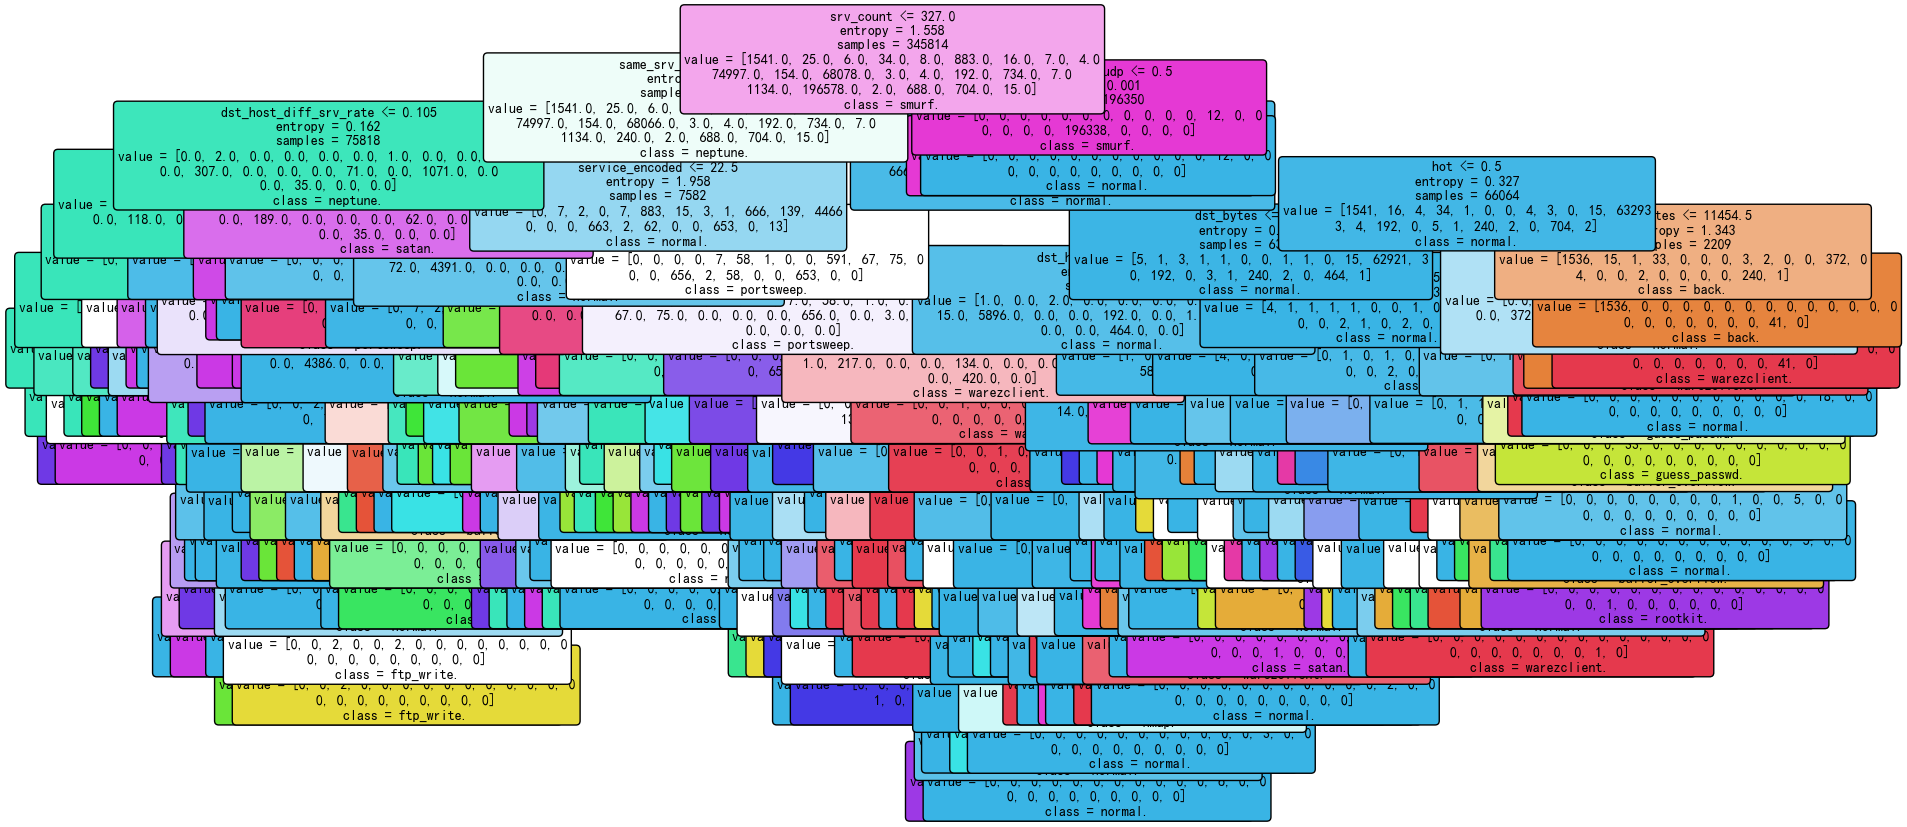

In [25]:
# 绘制决策树
plt.figure(figsize=(20, 10))  # 设置图形大小
tree.plot_tree(
    best_clf,  # 使用优化后的模型
    feature_names=X_encoded.columns,  # 特征名称
    class_names=label_encoder_y.classes_,  # 类别名称
    filled=True,  # 节点填充颜色
    rounded=True,  # 圆角节点
    fontsize=10  # 字体大小
)
plt.title("优化后的决策树")
plt.show()